In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sys
import numpy as np
import math
import numba
from numba import cuda, int64, jit
from numba.cuda import random as rnd
from timeit import default_timer as timer
from scipy.stats import binom, poisson
import pickle as pkl
import os

In order to efficiently encode our genomes, we will use only 2 bits per nucleotides as follow

 00: A, 01: T, 10: G, 11: C
 
We will use boolean arrays to do so:

In [68]:
test = np.zeros( 100 , dtype = '?') #boolean
test_device = cuda.to_device(test)

In [70]:
test

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [71]:
## nucleotide at index 2 -> indexes 4 and 5 in boolean array
test[4:6]

array([False, False])

Let's make a couple of helper functions to go back and forth between nucleotides and booleans:

In [4]:
def bin_to_seq(bin_genotype):
    seq = ""
    for i in range(0,len(bin_genotype),2):

        bin_nuc = bin_genotype[i:i+2]
        if bin_nuc[0] == False and bin_nuc[1] == False:
            seq += 'A' #00
        elif bin_nuc[0] == False and bin_nuc[1] == True:
            seq += 'T' #01
        elif bin_nuc[0] == True and bin_nuc[1] == False:
            seq += 'G' #10
        else:
            seq += 'C' #11
    return seq

bin_to_seq(test)

'AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA'

In [73]:
def seq_to_bin(genotype):
    bin_genotype = np.zeros( 2*len(genotype) , dtype = '?') #boolean
    for i in range(len(genotype)):
        if genotype[i] in "TC": # 01 or 11
            bin_genotype[ i*2 + 1 ] = True
        if genotype[i] in "GC": # 10 or 11
            bin_genotype[ i*2 ] = True
    return bin_genotype


for n in ["AAAA","TGCAGTAC","GACGTGTTGGATAAAAGGTTGTTGAGAGCAGAATACGCCAATACCGAATCTATCTGCAGGCTCT"]:
    x = seq_to_bin(n)
    n2 = bin_to_seq(x)
    print( n ,'->', x[:6] ,'... ->', n2 , 'same:',n==n2)

AAAA -> [False False False False False False] ... -> AAAA same: True
TGCAGTAC -> [False  True  True False  True  True] ... -> TGCAGTAC same: True
GACGTGTTGGATAAAAGGTTGTTGAGAGCAGAATACGCCAATACCGAATCTATCTGCAGGCTCT -> [ True False False False  True  True] ... -> GACGTGTTGGATAAAAGGTTGTTGAGAGCAGAATACGCCAATACCGAATCTATCTGCAGGCTCT same: True


From the standpoint of our GPU kernels, the modifications we need to make are with regard to:
 - the mutation process
 - the fitness computation



To manipulate booleans, we can use [bitwise operators](https://wiki.python.org/moin/BitwiseOperators)

 * x << y    Returns x with the bits shifted to the left by y places (and new bits on the right-hand-side are zeros). This is the same as multiplying x by 2**y. 
 * x >> y    Returns x with the bits shifted to the right by y places. This is the same as floor division of x by 2**y. 
 * x & y    Does a "bitwise and". Each bit of the output is 1 if the corresponding bit of x AND of y is 1, otherwise it's 0. 
 * x | y    Does a "bitwise or". Each bit of the output is 0 if the corresponding bit of x AND of y is 0, otherwise it's 1. 
 * ~ x    Returns the complement of x - the number you get by switching each 1 for a 0 and each 0 for a 1. This is the same as -x - 1. 
 * x ^ y    Does a "bitwise exclusive or". Each bit of the output is the same as the corresponding bit in x if that bit in y is 0, and it's the complement of the bit in x if that bit in y is 1. 


# mutate

In [6]:
## mutate - numpy version 

gene = "CCCCCCCC"
x = seq_to_bin(gene)

## mutate the nucleotide at index n:
n=2
mutate_by = np.random.randint(1,4) # random number between 1 and 3

x[ n*2 + 1 ] = x[ n*2 + 1 ] ^ ( ( mutate_by % 2 ) == 1 ) ## 01 and 11 give True
x[ n*2 ]     = x[ n*2 ] ^ ( ( mutate_by // 2 ) == 1 ) ## 10 and 11 give True

bin_to_seq(x)

'CCGCCCCC'

In [13]:

@cuda.jit
def mutate_genome_bin( rng_states, genomes , mutation_proba , genome_size):
    """
    rng_states : xoroshiro128p_uniform_float32 random states, shape (number of genomes)
    genomes : bool matrix (number of genomes,genome_size * 2)
    mutation_proba : float between 0 and 1. probability of mutation of a single nucleotide
    genome_size : int. number of nucleotides in each genome (NB: each nucleotide is represented by 2 )
    """

    cellID = cuda.grid(1)
    if cellID >= genomes.shape[0]:
        return

    for pos in range(genome_size):
        r = rnd.xoroshiro128p_uniform_float32(rng_states, cellID)    
        if r < mutation_proba:
            ## I re-use the random roll: divide by mutation_proba and then make it
            ## an int between 1 and 3
            mut = 1+ int( 3*r/mutation_proba )            
            bin_pos = 2*pos

            genomes[ cellID , bin_pos + 1 ] = genomes[ cellID , bin_pos + 1 ] ^ ( ( mut % 2 ) == 1 ) ## 01 and 11 give True
            genomes[ cellID , bin_pos ]     = genomes[ cellID , bin_pos ] ^ ( ( mut // 2 ) == 1 ) ## 10 and 11 give True

            

In [14]:
# Let's try it on simple data
number_of_genomes = 1000
genome_size = 50
mut_proba = 0.3 # for this test, let's make mutations highly likely

genomes = np.zeros( (number_of_genomes , genome_size*2) , dtype = "?" )

## sending to device + preparation
threads_per_block = 32
blocks = math.ceil( number_of_genomes/threads_per_block )

genomes_device = cuda.to_device(genomes)

rng_states = rnd.create_xoroshiro128p_states(threads_per_block * blocks, seed=1)

mutate_genome_bin[blocks, threads_per_block]( rng_states, genomes_device , 
                                              mut_proba, genome_size)


genomes = genomes_device.copy_to_host()
genomes[:5,:10]

/scicore/home/scicore/duchem0001/anaconda3/envs/gpu_course2/lib/python3.12/site-packages/numba_cuda/numba/cuda/dispatcher.py:696: NumbaPerformanceWarning: Grid size 32 will likely result in GPU under-utilization due to low occupancy.
  warn(errors.NumbaPerformanceWarning(msg))


array([[ True, False, False, False,  True,  True, False, False,  True,
         True],
       [False, False,  True,  True, False, False, False,  True,  True,
         True],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False,  True,
         True],
       [False, False, False, False, False, False, False, False, False,
        False]])

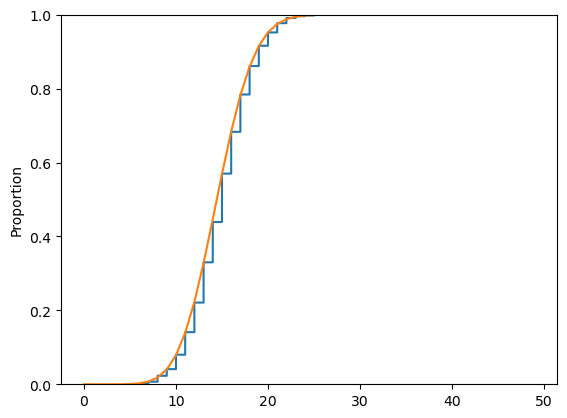

In [15]:
## spoiler on the fitness computation part to check results
sns.ecdfplot( ( genomes[:,::2] | genomes[:,1::2] ).sum(axis=1) )
plt.plot( binom( genome_size, mut_proba ).cdf(range(genome_size)) )

# fitness

In [9]:
reference = "CCCCCCCC"
genome    = "AAACCCCC" # 3 mutations

reference_bin = seq_to_bin(reference)
genome_bin    = seq_to_bin(genome)

XOR = reference_bin ^ genome_bin  ## 1 if the elements are different

## then, we use | to combine the 2 bits forming eahc nucleotide
## XOR[::2]  -> first bit of each nucleotide
## XOR[1::2] -> second bit of each nucleotide
## with | (or) if at least one of the two is 1 we get 1
np.sum( XOR[::2] | XOR[1::2] )

np.int64(3)

In [31]:
@cuda.jit
def compute_fitness_bin( genomes, reference, fitness_array, s, genome_size ):
    """
    genomes : bool matrix (number of genomes,genome_size * 2)
    reference : reference genomes to compare the genomes to. shape (genome_size * 2) 
    fitness_array : array of fitnesses. shape (number of genomes)
    s : float. between 0 and 1
    genome_size : int. number of nucleotides in each genome (NB: each nucleotide is represented by 2 )

    fitness is computed as s**(number of difference with the reference genome)
    """
    
    cellID = cuda.grid(1)
    if cellID >= genomes.shape[0]:
        return
    
    n = 0    
    for i in range(genome_size):
        p = i*2        
        n += (genomes[cellID , p ] ^ reference[p]) | (genomes[cellID , p+1 ] ^ reference[p+1])
    
    fitness_array[cellID] = s**n
    


In [47]:
## let's some toy data:
number_of_genomes = 1000
genome_size = 100

s = 0.999

genomes = np.random.random((number_of_genomes,genome_size*2)) < 0.5

reference = np.zeros( genome_size*2,
                      dtype='?')

fitness_array = np.zeros(number_of_genomes)

## sending to device + preparation
threads_per_block = 32
blocks = math.ceil( number_of_genomes/threads_per_block )

genomes_device = cuda.to_device(genomes)
reference_device = cuda.to_device( reference )
fitness_array_device = cuda.to_device( fitness_array )

rng_states = rnd.create_xoroshiro128p_states(threads_per_block * blocks, seed=46521)


compute_fitness_bin[ blocks, threads_per_block ]( genomes_device,
                                                 reference_device ,
                                                 fitness_array_device,
                                                 s,
                                                 genome_size )

(array([ 21.,  80., 100., 241., 180., 206.,  78.,  70.,  16.,   8.]),
 array([0.91755475, 0.91987873, 0.9222027 , 0.92452668, 0.92685066,
        0.92917464, 0.93149862, 0.93382259, 0.93614657, 0.93847055,
        0.94079453]),
 <BarContainer object of 10 artists>)

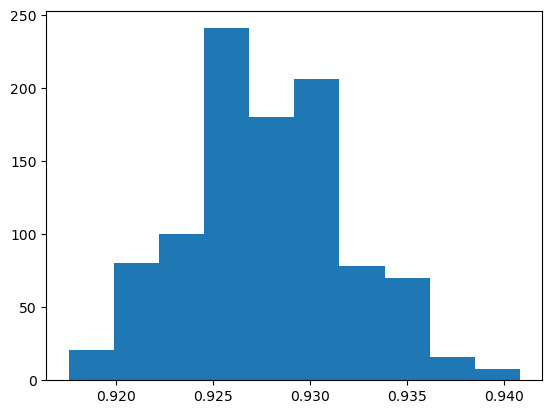

In [48]:
fitness_array = fitness_array_device.copy_to_host()
plt.hist( fitness_array )

(200,)

In [60]:
for i,gen in enumerate( genomes[:10,:] ):
    XOR = reference ^ gen  ## 1 if the elements are different
    n = np.sum( XOR[::2] | XOR[1::2] )
    print( f"number of mutations: {n} -  CPU fitness: {s**n} - GPU fitness: {fitness_array[i]} - same: {np.isclose(s**n , fitness_array[i])}" )

number of mutations: 72 -  CPU fitness: 0.9304973749532336 - GPU fitness: 0.9304973749532341 - same: True
number of mutations: 77 -  CPU fitness: 0.9258541837518948 - GPU fitness: 0.9258541837518953 - same: True
number of mutations: 76 -  CPU fitness: 0.9267809647166114 - GPU fitness: 0.926780964716612 - same: True
number of mutations: 83 -  CPU fitness: 0.9203129279589383 - GPU fitness: 0.9203129279589389 - same: True
number of mutations: 81 -  CPU fitness: 0.9221563184394989 - GPU fitness: 0.9221563184394995 - same: True
number of mutations: 80 -  CPU fitness: 0.9230793978373362 - GPU fitness: 0.9230793978373368 - same: True
number of mutations: 76 -  CPU fitness: 0.9267809647166114 - GPU fitness: 0.926780964716612 - same: True
number of mutations: 71 -  CPU fitness: 0.9314288037569906 - GPU fitness: 0.9314288037569911 - same: True
number of mutations: 71 -  CPU fitness: 0.9314288037569906 - GPU fitness: 0.9314288037569911 - same: True
number of mutations: 77 -  CPU fitness: 0.925854

# putting everything together

In [35]:
## we reuse the functions we defined in the previous notebook
@cuda.reduce
def sum_reduce(a, b):
  """ compute the sum of all elements in an array"""
  return a+b

@cuda.jit
def multinomial(rng_states,out,fitnessarr,fitness_sum):
  """
    Randomly draws parents for each cells according to their fitnesses

      args:
        - rng_states   : array of xoroshiro random states (size equal to output array)
        - out          : output array containing the randomly drawn index of the parent for each individual
        - fitnessarr   : array of parent fitnesses
        - fitness_sum  : sum of all parent fitnesses
  """
  cellID = cuda.grid(1)
  #this is how you would get a multinomially distributed random variable
  r=fitness_sum*rnd.xoroshiro128p_uniform_float32(rng_states, cellID)
  for i in range(len(fitnessarr)):
    if r<fitnessarr[i]:
      parent=i
      break
    else:
      r-=fitnessarr[i]
  out[cellID]=parent

@cuda.jit
def copy_genomes( parents_genomes, children_genomes , parent_attribution ):

  cellID = cuda.grid(1)
  if cellID >= parents_genomes.shape[0]:
    return
  parentID = parent_attribution[ cellID ]

  for i in range(parents_genomes.shape[1]):
    children_genomes[ cellID , i ] = parents_genomes[ parentID , i ]


In [62]:
## let's some toy data:
number_of_genomes = 10_000
genome_size = 10_000
mut_proba = 10**-5
s = 0.999


threads_per_block = 32
blocks = math.ceil( number_of_genomes/threads_per_block )



## holds the genomes for the older and the new generation
genomes_device = [
    cuda.to_device( np.random.random((number_of_genomes,genome_size*2)) < 0.5 ),
    cuda.to_device( np.random.random((number_of_genomes,genome_size*2)) < 0.5 )
]

# "reference" genomes (ie, max fitness)
reference_device = cuda.to_device( np.zeros( genome_size*2, dtype='?') )

# array of fitnesses
fitness_array_device = cuda.to_device( np.ones(number_of_genomes) )

# array of parent attribution
parent_attribution_device = cuda.to_device( np.zeros(number_of_genomes, dtype = np.int32) )

# random states
rng_states = rnd.create_xoroshiro128p_states(threads_per_block * blocks, seed=1)



## first fitness computation
compute_fitness_bin[ blocks, threads_per_block ]( genomes_device[0],
                                                 reference_device ,
                                                 fitness_array_device,
                                                 s,
                                                 genome_size )

In [63]:
A = fitness_array_device.copy_to_host()
print("mean fitness:",A.mean())
print("max fitness:",A.max())

mean fitness: 0.0005516463419456116
max fitness: 0.0006584226928731755


Let's do a single round of evolution:

In [64]:
%%time
## computing fitness sum:
fitness_sum=sum_reduce(fitness_array_device)

## parent attribution
multinomial[blocks, threads_per_block](rng_states,
                                     parent_attribution_device,
                                     fitness_array_device,
                                     fitness_sum)

## copying parents
copy_genomes[ blocks, threads_per_block ]( genomes_device[0],
                                           genomes_device[1],
                                           parent_attribution_device )

## mutating genomes
mutate_genome_bin[blocks, threads_per_block]( rng_states,
                                              genomes_device[1] ,
                                              mut_proba,
                                              genome_size )

## update fitness
compute_fitness_bin[ blocks, threads_per_block ]( genomes_device[1],
                                                 reference_device ,
                                                 fitness_array_device,
                                                 s,
                                                 genome_size )

A = fitness_array_device.copy_to_host()
print("mean fitness:",A.mean())
print("max fitness:",A.max())

mean fitness: 0.0005524464469802315
max fitness: 0.0006453785919053632
CPU times: user 11.9 ms, sys: 0 ns, total: 11.9 ms
Wall time: 10.9 ms


In [66]:
%%time
nb_generations = 1000

for i in range(  nb_generations ):

  ## on even generations, parents are in index 0, children in index 1
  ## on odd generations we do the converse
  parents_index , children_index = 0,1
  if i%2==1:
    parents_index , children_index = 1,0

  ## computing fitness sum:
  fitness_sum=sum_reduce(fitness_array_device)

  ## parent attribution
  multinomial[blocks, threads_per_block](rng_states,
                                         parent_attribution_device,
                                         fitness_array_device,
                                         fitness_sum )

  ## copying parents
  copy_genomes[ blocks, threads_per_block ]( genomes_device[parents_index],
                                             genomes_device[children_index],
                                             parent_attribution_device )

  ## mutating genomes
  mutate_genome_bin[blocks, threads_per_block]( rng_states,
                                            genomes_device[children_index] ,
                                            mut_proba,
                                            genome_size )

  ## update fitness
  compute_fitness_bin[ blocks, threads_per_block ]( genomes_device[children_index],
                                                  reference_device ,
                                                  fitness_array_device,
                                                  s,
                                                  genome_size )

  if i%100 == 0:
    A = fitness_array_device.copy_to_host()
    print(f"generation {i:>3} : mean fitness: {A.mean():.5f}\t|\tmax fitness: {A.max():.5f}\t")

generation   0 : mean fitness: 0.00066	|	max fitness: 0.00067	
generation 100 : mean fitness: 0.00066	|	max fitness: 0.00067	
generation 200 : mean fitness: 0.00066	|	max fitness: 0.00067	
generation 300 : mean fitness: 0.00066	|	max fitness: 0.00067	
generation 400 : mean fitness: 0.00066	|	max fitness: 0.00067	
generation 500 : mean fitness: 0.00066	|	max fitness: 0.00067	
generation 600 : mean fitness: 0.00067	|	max fitness: 0.00067	
generation 700 : mean fitness: 0.00067	|	max fitness: 0.00068	
generation 800 : mean fitness: 0.00067	|	max fitness: 0.00068	
generation 900 : mean fitness: 0.00067	|	max fitness: 0.00068	
CPU times: user 9.49 s, sys: 0 ns, total: 9.49 s
Wall time: 9.47 s


9.0